In [ ]:
### ARCHITECTURE SEARCH ###

import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import f0dl_bernox
human_results_dict = f0dl_bernox.bernox2005_human_results_dict()


def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value

def calc_num_layers(brain_arch_fn):
    with open(brain_arch_fn) as f: brain_arch = json.load(f)
    num_conv_layers = 0
    for layer_dict in brain_arch:
        if layer_dict['layer_type'] == 'tf.layers.conv2d':
            num_conv_layers = num_conv_layers + 1
    return num_conv_layers


results_dict_regex = '/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v00/arch_*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json'
results_dict_fn_list = sorted(glob.glob(results_dict_regex))
valid_dict_fn_list = []
arch_dict_fn_list = []
for fn in results_dict_fn_list:
    output_dir, _ = os.path.split(fn)
    valid_dict_fn_list.append(os.path.join(output_dir, 'validation_metrics.json'))
    arch_dict_fn_list.append(os.path.join(output_dir, 'brain_arch.json'))

results_dict_list = []
valid_metric_list = []
arch_stat_list = []
for idx, (rdfn, vfn, afn) in enumerate(zip(results_dict_fn_list, valid_dict_fn_list, arch_dict_fn_list)):
    results_dict_list.append(load_results_dict(rdfn))
    valid_metric_list.append(calc_best_metric(vfn))
    arch_stat_list.append(calc_num_layers(afn))

print(len(results_dict_list))


In [ ]:
tmp_valid_metric_list = valid_metric_list.copy()
tmp_arch_stat_list = arch_stat_list.copy()

sort_idx = np.flip(np.argsort(valid_metric_list)).tolist()

model_idx_list = []
for idx in sort_idx:
    if tmp_arch_stat_list[idx] == 8:
        model_idx_list.append(idx)

len(model_idx_list)

In [ ]:
### PLOT THRESHOLDS f0dl_bernox.py ###

def make_threshold_plot(ax, results_dict, title_str=None, legend_on=True,
                        sine_plot_kwargs={}, rand_plot_kwargs={},
                        xlabel='Lowest harmonic number',
                        ylabel='F0 discrimination threshold (%F0)'):
    phase_mode_list = np.array(results_dict['phase_mode'])
    low_harm_list = np.array(results_dict['low_harm'])
    f0dl_list = np.array(results_dict['f0dl'])
    unique_phase_modes = np.unique(phase_mode_list)
    for phase_mode in unique_phase_modes:
        x = low_harm_list[phase_mode_list == phase_mode]
        y = f0dl_list[phase_mode_list == phase_mode]
        
        if phase_mode == 0:
            plot_kwargs = {'label': 'sine', 'color': 'b', 'ls':'-', 'lw':2, 'ms':8, 'marker':''}
            plot_kwargs.update(sine_plot_kwargs)
        else:
            plot_kwargs = {'label': 'rand', 'color': 'b', 'ls':'--', 'lw':2, 'ms':8, 'marker':''}
            plot_kwargs.update(rand_plot_kwargs)
        
        if not legend_on: plot_kwargs['label'] = None
        ax.plot(x, y, **plot_kwargs)

    ax.set_yscale('log')
    ax.set_ylim([1e-1, 3e2])
    ax.set_xlim([0, 32])
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    if title_str is not None: ax.set_title(title_str, fontsize=10)
    if legend_on: ax.legend(loc='lower right', frameon=False, fontsize=10)

        
# model_idx_list = list(range(len(results_dict_list)))
        
NCOLS = 6
NROWS = int(np.ceil(len(model_idx_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(0.75*4*NCOLS, 0.75*3*NROWS))
ax_arr = ax_arr.flatten()

for ax_idx, model_idx in enumerate(model_idx_list):
    
    results_dict = results_dict_list[model_idx]
    
    title_str = 'n_layers={:d}, valid_acc={:.4f}'.format(arch_stat_list[model_idx], valid_metric_list[model_idx])
    
    ax = ax_arr[ax_idx]
    make_threshold_plot(ax, human_results_dict, title_str=None, legend_on=False,
                        sine_plot_kwargs={'color':'r', 'lw':0.5}, rand_plot_kwargs={'color':'r', 'lw':0.5})
    make_threshold_plot(ax, results_dict, title_str=title_str, legend_on=True,
                        sine_plot_kwargs={'color':'k', 'lw':2}, rand_plot_kwargs={'color':'b', 'lw':2},
                        ylabel='F0DL (%F0)')

for ax_idx in range(len(model_idx_list), len(ax_arr)): ax_arr[ax_idx].axis('off')

plt.tight_layout()
plt.show()

fig.savefig('figures/archive_2019_08_28_archSearch00_RSBpsychophysics/2019AUG28_arch_search_v00_bernox2005_nlayers8.pdf', bbox_inches='tight')



In [ ]:
# bernox2005

import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
human_results_dict = util_human_model_comparison.get_human_results_dict_bernox2005(average_conditions=True)


def make_threshold_plot(ax, results_dict, title_str=None, legend_on=True,
                        sine_plot_kwargs={}, rand_plot_kwargs={},
                        xlabel='Lowest harmonic number',
                        ylabel='F0 discrimination threshold (%F0)'):
    phase_mode_list = np.array(results_dict['phase_mode'])
    low_harm_list = np.array(results_dict['low_harm'])
    f0dl_list = np.array(results_dict['f0dl'])
    unique_phase_modes = np.unique(phase_mode_list)
    for phase_mode in unique_phase_modes:
        x = low_harm_list[phase_mode_list == phase_mode]
        y = f0dl_list[phase_mode_list == phase_mode]
        
        if phase_mode == 0:
            plot_kwargs = {'label': 'sine', 'color': 'b', 'ls':'-', 'lw':2, 'ms':8, 'marker':''}
            plot_kwargs.update(sine_plot_kwargs)
        else:
            plot_kwargs = {'label': 'rand', 'color': 'b', 'ls':'--', 'lw':2, 'ms':8, 'marker':''}
            plot_kwargs.update(rand_plot_kwargs)
        
        if not legend_on: plot_kwargs['label'] = None
        ax.plot(x, y, **plot_kwargs)

    ax.set_yscale('log')
    ax.set_ylim([1e-1, 3e2])
    ax.set_xlim([0, 32])
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    if title_str is not None: ax.set_title(title_str, fontsize=10)
    if legend_on: ax.legend(loc='lower right', frameon=False, fontsize=10)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
make_threshold_plot(ax, human_results_dict, title_str=None, legend_on=True,
                    sine_plot_kwargs={}, rand_plot_kwargs={},
                    xlabel='Lowest harmonic number',
                    ylabel='F0 discrimination threshold (%F0)')
plt.show()

In [ ]:
# transposed tones

import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
human_results_dict = util_human_model_comparison.get_human_results_dict_transposedtones()


def make_TT_threshold_plot(ax, results_dict, title_str=None, legend_on=True):
    f0_ref = np.array(results_dict['f0_ref'])
    f_carrier_list = np.array(results_dict['f_carrier'])
    f0dl_list = np.array(results_dict['f0dl'])
    unique_f_carrier_list = np.unique(f_carrier_list)
    for f_carrier in unique_f_carrier_list:
        x = f0_ref[f_carrier_list == f_carrier]
        y = f0dl_list[f_carrier_list == f_carrier]
        
        if f_carrier > 0:
            label = '{}-Hz TT'.format(int(f_carrier))
            plot_kwargs = {'label': label, 'color': 'k', 'ls':'-', 'lw':2, 'ms':6,
                           'marker':'o', 'markerfacecolor': 'w'}
            if int(f_carrier) == 10080: plot_kwargs['marker'] = 'D'
            if int(f_carrier) == 6350: plot_kwargs['marker'] = '^'
            if int(f_carrier) == 4000: plot_kwargs['marker'] = 's'
        else:
            label = 'Pure tone'
            plot_kwargs = {'label': label, 'color': 'k', 'ls':'-', 'lw':2, 'ms':6,
                           'marker':'o', 'markerfacecolor': 'k'}
            
        if not legend_on: plot_kwargs['label'] = None
        ax.plot(x, y, **plot_kwargs)

    ax.set_yscale('log')
    ax.set_ylim([5e-1, 3e1])
    ax.set_xscale('log')
    ax.set_xlim([40, 500])
    ax.set_xlabel('Frequency (Hz)', fontsize=10)
    ax.set_ylabel('Frequency difference (%)', fontsize=10)
    if title_str is not None: ax.set_title(model_name, fontsize=10)
    if legend_on: ax.legend(loc='lower left', frameon=False, fontsize=8, handlelength=0)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
make_TT_threshold_plot(ax, human_results_dict, title_str=None, legend_on=True)
plt.show()

In [ ]:
# freq-shifted complexes

import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
human_results_dict = util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes()
results_dict_list = [human_results_dict]


for results_dict in results_dict_list:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
    key_to_label_map={5:'RES', 11:'INT', 16:'UNRES'}
    filter_key='spectral_envelope_centered_harmonic'
    for key in sorted(results_dict[filter_key].keys()):
        xval = results_dict[filter_key][key]['f0_shift']
        yval = results_dict[filter_key][key]['f0_pred_shift_median']
        
        assert results_dict[filter_key][key]['f0_pred_shift_median'] == results_dict[filter_key][key]['f0_pred_shift_mean']
        
        yerr = results_dict[filter_key][key]['f0_pred_shift_stddev']
        ax.plot(xval, yval, '.-', label=key_to_label_map.get(key, key))

    ax.legend(loc=2, frameon=False)
    ax.set_xlabel('Component shift (%F0)')
    ax.set_ylabel('Shift in predicted F0 (%F0)')
    ax.set_xlim([-0.5, 24.5])
    ax.set_ylim([-4, 12])
    plt.show()


TypeError: make_mistuned_harmonics_bar_graph() got an unexpected keyword argument 'key_pitch_shift'

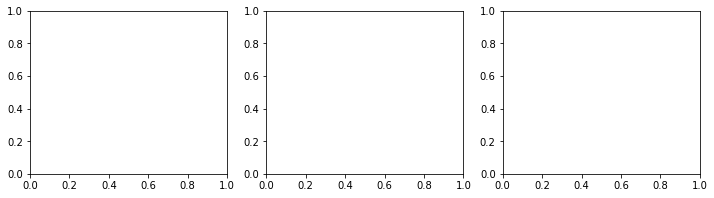

In [1]:
# mistuned harmonics

import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
human_results_dict = util_human_model_comparison.get_human_results_dict_mistunedharmonics()
results_dict_list = [human_results_dict]

fn_results_dict = '/om2/user/msaddler/pitchnet/saved_models/PND_v04_JWSS_halfbandpass_classification2/EVAL_MistunedHarm_v00_bestckpt_results_dict.json'
with open(fn_results_dict) as f:
    results_dict = json.load(f)

results_dict_list.append(results_dict)


def make_mistuned_harmonics_bar_graph(ax, results_dict, mistuned_pct=3.0,
                                      pitch_shift_key='f0_pred_pct_median',
                                      legend_on=True, barwidth=0.12):
    '''
    '''
    bar_graph_results_dict = util_human_model_comparison.get_mistuned_harmonics_bar_graph_results_dict(
        results_dict, mistuned_pct=mistuned_pct, pitch_shift_key=pitch_shift_key)

    num_groups = len(bar_graph_results_dict.keys())
    group_xoffsets = np.arange(num_groups) - np.mean(np.arange(num_groups))
    
    for group_idx, group_key in enumerate(sorted(bar_graph_results_dict.keys())):
        bars_per_group = len(bar_graph_results_dict[group_key]['f0_ref'])
        xvals = np.arange(bars_per_group)
        yvals = np.array(bar_graph_results_dict[group_key][pitch_shift_key])
        
        xvals = xvals + barwidth*group_xoffsets[group_idx]
        ax.bar(xvals, yvals, width=barwidth, edgecolor='white', label=group_key)

    base_xvals = np.arange(bars_per_group)
    f0_ref_values = bar_graph_results_dict[group_key]['f0_ref']
    
    ax.set_xlim([barwidth*group_xoffsets[0]-0.5,
                 np.max(base_xvals) + barwidth*group_xoffsets[-1] + 1])
    ax.set_xlabel('F0 (Hz)')
    ax.set_xticks(base_xvals)
    ax.set_xticklabels(f0_ref_values)
    
    if legend_on: ax.legend(loc='upper right', frameon=False, fontsize=10)
        


NCOLS = 3
NROWS = int(np.ceil(len(results_dict_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))
ax_arr = ax_arr.flatten()

for idx, results_dict in enumerate(results_dict_list):
    ax = ax_arr[idx]
    make_mistuned_harmonics_bar_graph(ax, results_dict, mistuned_pct=3.0,
                                      pitch_shift_key='f0_pred_pct_median')
    
for idx in range(len(results_dict_list), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()




In [ ]:
# Alt-phase complexes

import sys
import os
import json
import numpy as np
import glob
import f0dl_bernox
%matplotlib inline
import matplotlib.pyplot as plt
import pdb

import util_human_model_comparison
human_results_dict = util_human_model_comparison.get_human_results_dict_altphasecomplexes()
results_dict_list = [human_results_dict]

# results_dict_list = util_human_model_comparison.get_human_results_dict_altphasecomplexes(average_conditions=False)

NCOLS = 3
NROWS = int(np.ceil(len(results_dict_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(3.5*NCOLS, 3*NROWS))
ax_arr = ax_arr.flatten()

for idx, results_dict in enumerate(results_dict_list):
    ax = ax_arr[idx]
    
    for key in sorted(results_dict['filter_fl_bin_means'].keys()):
        ax.plot(results_dict['f0_bin_centers'], results_dict['filter_fl_bin_means'][key], 'o-', label=key)
    
    ax.legend(loc=0, frameon=False, handlelength=2, markerscale=0, fontsize=8)
    ax.set_xscale('log')
    

for idx in range(len(results_dict_list), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()